# Customer Lifetime Value Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
# for plotting 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for plotting 
import plotly.express as px
import pandas as pd
import plotly

In [3]:
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

ref: https://medium.com/analytics-vidhya/customer-life-time-value-prediction-by-using-bg-nbd-gamma-gamma-models-and-applied-example-in-997a5ee481ad

In [4]:
df = pd.read_csv("/Users/nemisha/Desktop/CLV_ML2/Online Retail.xlsx - Online Retail.csv")

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


Invoice: Invoice number. If this number starts with ‘C’, it means this transaction is cancelled.
 
 
StockCode: Product code


Description: Product Name


Quantity: Product counts


InvoiceDate: Transaction date


Price: A single product price


CustomerID: Unique customer number


Country: Customer’s country name

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### EDA

In [7]:
df.dropna(inplace=True)
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

choose data which Invoice column doesn’t start with ‘C’. Because if it starts with ‘C’, it means this is a cancelled transaction. And then I’ll filter the Quantity column and I’ll calculate TotalPrice for each

In [8]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France,16.60


In [9]:
df.shape

(397924, 9)

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [11]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')

In [12]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749
std,180.420210,22.096788,1713.169877,309.055588
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


In [13]:
df['Country'].value_counts()

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [14]:
# remove duplicate rows
df = df.drop_duplicates()

In [15]:
# remove duplicate rows
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')

<AxesSubplot:>

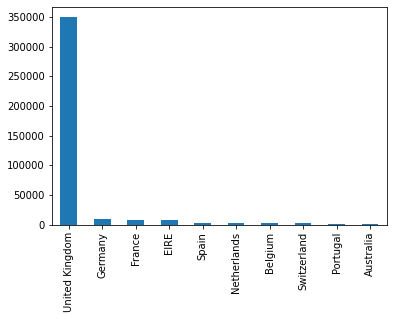

In [16]:
# Plot the bar chart of countries
df.Country.value_counts()[:10].plot(kind='bar')

In [17]:
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [18]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


### Feature aggregation

The lifetime package is based on transaction data only. For each customer, aggregate:

-recency: days between first and last purchase in the given period.

-frequency: number of repeated purchase in the given period, it's the count of days the customer had a repeated purchase on.

-T: customer age, days since first purchase.

-monetary_value: transaction value in the given period.

In [19]:
df['amt'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [20]:
cust = df.groupby(['CustomerID']).agg({
    'InvoiceNo': 'count',
    'amt': 'sum'
}).reset_index()

In [21]:
cust.describe()

,CustomerID,InvoiceNo,amt
count,4339.000000,4339.000000,4339.000000
mean,15299.936852,90.512100,2048.215924
std,1721.889758,225.515328,8984.248352
min,12346.000000,1.000000,0.000000
25%,13812.500000,17.000000,306.455000
50%,15299.000000,41.000000,668.560000
75%,16778.500000,98.000000,1660.315000
max,18287.000000,7676.000000,280206.020000


In [165]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2011-12-9')

modeldata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [181]:
modeldata_base = modeldata;

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


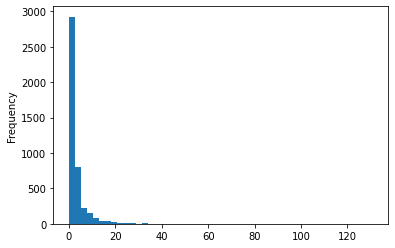

In [195]:
modeldata['frequency'].plot(kind='hist', bins=50) 
print(modeldata['frequency'].describe())
# frequency=0 means no repeated purchase. 35.7% customers left after one purchase.
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

In [196]:
modeldata = modeldata[modeldata['monetary_value'] > 0]
modeldata['monetary_value'] = modeldata['monetary_value'] / modeldata['frequency']

In [197]:
# transforming days to weeks
modeldata['recency'] = modeldata['recency'] / 7
modeldata['T'] = modeldata['T'] / 7

In [198]:
modeldata = modeldata[(modeldata['frequency'] > 1)]

In [199]:
modeldata

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,52.142857,52.428571,99.950278
12348.0,3.0,40.428571,51.142857,100.493333
12352.0,6.0,37.142857,42.285714,61.376111
12356.0,2.0,43.285714,46.428571,134.952500
12359.0,3.0,39.142857,47.285714,640.281111
...,...,...,...,...
18263.0,2.0,32.428571,36.000000,226.390000
18272.0,5.0,34.857143,35.142857,97.550400
18273.0,2.0,36.428571,36.714286,38.250000


In [121]:
#df.to_csv('modeldata.csv', index=False)

In [80]:
#os.getcwd()

'/Users/nemisha'

## BG/NBD model

In [200]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1916 subjects, a: 0.02, alpha: 16.22, b: 13.28, r: 2.44>


In [201]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, # week
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0    1.919373
12748.0    1.660499
17841.0    1.631671
15311.0    1.315242
14606.0    1.300814
12971.0    1.043945
13089.0    0.977962
14527.0    0.803921
13798.0    0.784567
16422.0    0.715983
dtype: float64

Top 10 customers expected to make the most purchases in a week

In [202]:
week=bgf.conditional_expected_number_of_purchases_up_to_time(1, # week
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

In [203]:
top_week = pd.DataFrame(week)
top_week.head(10)

,0
CustomerID,
14911.0,1.919373
12748.0,1.660499
17841.0,1.631671
15311.0,1.315242
14606.0,1.300814
12971.0,1.043945
13089.0,0.977962
14527.0,0.803921
13798.0,0.784567


In [90]:
#df.to_excel('top_week.xlsx', sheet_name='sheet1', index=False)

In [122]:
#df.to_csv('top_week.csv', index=False)

In [204]:
bgf.conditional_expected_number_of_purchases_up_to_time(4, 
                                                 # 4 weeks = 1 month
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0    7.675030
12748.0    6.639887
17841.0    6.524614
15311.0    5.259333
14606.0    5.201637
12971.0    4.174508
13089.0    3.910660
14527.0    3.214731
13798.0    3.137347
16422.0    2.863098
dtype: float64

Top 10 customers expected to make the most purchases in a month

In [205]:
month= bgf.conditional_expected_number_of_purchases_up_to_time(4, 
                                                 # 4 weeks = 1 month
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

In [206]:
top_month = pd.DataFrame(month)
top_month.head(10)

,0
CustomerID,
14911.0,7.675030
12748.0,6.639887
17841.0,6.524614
15311.0,5.259333
14606.0,5.201637
12971.0,4.174508
13089.0,3.910660
14527.0,3.214731
13798.0,3.137347


In [95]:
#df.to_excel('top_month.xlsx', sheet_name='sheet1', index=False)

In [123]:
#df.to_csv('top_month.csv', index=False)

In [207]:
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6, 
                                           # weeks * count = months
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

CustomerID
14911.0    45.960528
12748.0    39.762489
17841.0    39.072275
15311.0    31.496222
14606.0    31.150758
12971.0    25.000555
13089.0    23.420500
14527.0    19.253504
13798.0    18.790312
16422.0    17.148013
dtype: float64

Top 10 customers expected to make the most purchases in next 6 months

In [208]:
six_month= bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6, 
                                           # weeks * count = months
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sort_values(ascending=False).head(10)

In [209]:
six_month = pd.DataFrame(six_month)
six_month.head(10)

,0
CustomerID,
14911.0,45.960528
12748.0,39.762489
17841.0,39.072275
15311.0,31.496222
14606.0,31.150758
12971.0,25.000555
13089.0,23.420500
14527.0,19.253504
13798.0,18.790312


In [98]:
#df.to_excel('six_month.xlsx', sheet_name='sheet1', index=False)

In [124]:
#df.to_csv('six_month.csv', index=False)

In [210]:
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        modeldata['frequency'],
                                                        modeldata['recency'],
                                                        modeldata['T']).sum()

6852.657572450366

The count of total transactions expected in next 6 months

### Predict future transaction number

In [211]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])


In [212]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,53.142857,53.285714,1.533811,1.300814
15311.0,89.0,53.285714,53.285714,7.597875,1.315242
17841.0,111.0,53.142857,53.285714,3.245468,1.631671
12748.0,113.0,53.285714,53.285714,2.588162,1.660499
14911.0,131.0,53.142857,53.285714,8.341926,1.919373


In [213]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15107.0,5.0,8.714286,53.142857,8.1400,0.036886
16725.0,5.0,9.857143,53.000000,25.4448,0.045813
15100.0,2.0,5.714286,53.285714,131.4000,0.053623
15881.0,2.0,7.428571,52.000000,96.7350,0.057797
13819.0,2.0,2.571429,45.571429,183.0125,0.058637


In [214]:
# Lowest 5 customers
df_modeldata=modeldata.sort_values(by='predicted_purchases').head(5)

In [215]:
df_modeldata

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15107.0,5.0,8.714286,53.142857,8.1400,0.036886
16725.0,5.0,9.857143,53.000000,25.4448,0.045813
15100.0,2.0,5.714286,53.285714,131.4000,0.053623
15881.0,2.0,7.428571,52.000000,96.7350,0.057797
13819.0,2.0,2.571429,45.571429,183.0125,0.058637


In [100]:
#df.to_excel('df_modeldata.xlsx', sheet_name='sheet1', index=False)

In [125]:
#df.to_csv('df_modeldata.csv', index=False)

In [217]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )

In [218]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,225.0,0.0,100.0
12347.0,4.0,238.0,267.0,2.0,100.0
12348.0,2.0,110.0,258.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0
12352.0,3.0,34.0,196.0,3.0,100.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

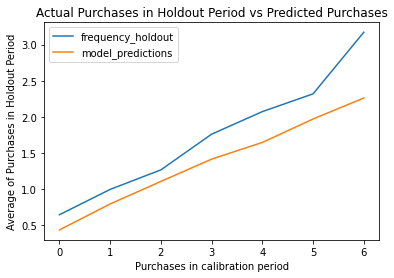

In [219]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

The model is good because model prediction (orange line) and true data (blue line) overlap

In [220]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])


In [221]:
summary_cal_holdout


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,
12346.0,0.0,0.0,225.0,0.0,100.0,0.248374
12347.0,4.0,238.0,267.0,2.0,100.0,1.418368
12348.0,2.0,110.0,258.0,1.0,100.0,0.840423
12350.0,0.0,0.0,210.0,0.0,100.0,0.261874
12352.0,3.0,34.0,196.0,3.0,100.0,1.421056
...,...,...,...,...,...,...
18280.0,0.0,0.0,177.0,0.0,100.0,0.297442
18281.0,0.0,0.0,80.0,0.0,100.0,0.495104
18282.0,0.0,0.0,26.0,1.0,100.0,0.785816


In [112]:
#holdout=summary_cal_holdout

In [113]:
#df.to_excel('holdout.xlsx', sheet_name='sheet1', index=False)

In [126]:
#df.to_csv('holdout.csv', index=False)

In [223]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [224]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))


RMSE:  1.6297864859747002
SMAPE 1.21430229288416
R2:  0.5610201509609365


In [225]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.2725764006672178

### Historical probability of being alive

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

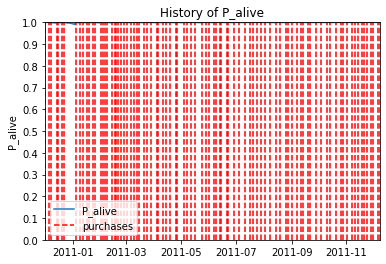

In [226]:
# Customer 14606
# frequent customer, alive throughout the year.
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

## Gamma-Gamma Submodel

In [227]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(modeldata['frequency'], modeldata['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1916 subjects, p: 3.70, q: 0.55, v: 3.62>

In [228]:
ggf.conditional_expected_average_profit(modeldata['frequency'],
                               modeldata['monetary_value']).sort_values(ascending=False).head(10)

CustomerID
12798.0    1431.610736
12409.0    1297.318780
16532.0    1290.079831
16303.0    1208.891251
13802.0     968.275401
17396.0     804.269267
12754.0     791.359107
12744.0     789.018345
14175.0     773.933980
12557.0     733.968390
dtype: float64

The top 10 customers expected to be most valuable

In [229]:
gamma = ggf.conditional_expected_average_profit(modeldata['frequency'],
                               modeldata['monetary_value']).sort_values(ascending=False)

In [115]:
#df.to_excel('gamma.xlsx', sheet_name='sheet1', index=False)

In [127]:
#df.to_csv('gamma.csv', index=False)

## Predicting CLV by Using BG-NBD and Gamma-Gamma Models

In [230]:
# The customers' lifetime values expected to in the next 3 months
modeldata['modeldata_pred_3_months'] = ggf.customer_lifetime_value(bgf,
                                   modeldata['frequency'],
                                   modeldata['recency'],
                                   modeldata['T'],
                                   modeldata['monetary_value'],
                                   time=3,  # 3 months
                                   freq="W",  
# frequency information of T. In this case we set week by using 'W'
                                   discount_rate=0.01)
modeldata

,frequency,recency,T,monetary_value,predicted_purchases,modeldata_pred_3_months
CustomerID,,,,,,
12347.0,6.0,52.142857,52.428571,99.950278,0.122824,160.984995
12348.0,3.0,40.428571,51.142857,100.493333,0.080531,109.028992
12352.0,6.0,37.142857,42.285714,61.376111,0.143970,116.298582
12356.0,2.0,43.285714,46.428571,134.952500,0.070765,131.629090
12359.0,3.0,39.142857,47.285714,640.281111,0.085463,729.825163
...,...,...,...,...,...,...
18263.0,2.0,32.428571,36.000000,226.390000,0.084885,263.435528
18272.0,5.0,34.857143,35.142857,97.550400,0.144698,186.098098
18273.0,2.0,36.428571,36.714286,38.250000,0.083773,45.637575


### segment our customers by using their CLV values

In [231]:
modeldata['segment'] = pd.qcut(modeldata['modeldata_pred_3_months'],4,['D','C','B','A'])

modeldata

,frequency,recency,T,monetary_value,predicted_purchases,modeldata_pred_3_months,segment
CustomerID,,,,,,,
12347.0,6.0,52.142857,52.428571,99.950278,0.122824,160.984995,B
12348.0,3.0,40.428571,51.142857,100.493333,0.080531,109.028992,C
12352.0,6.0,37.142857,42.285714,61.376111,0.143970,116.298582,C
12356.0,2.0,43.285714,46.428571,134.952500,0.070765,131.629090,B
12359.0,3.0,39.142857,47.285714,640.281111,0.085463,729.825163,A
...,...,...,...,...,...,...,...
18263.0,2.0,32.428571,36.000000,226.390000,0.084885,263.435528,A
18272.0,5.0,34.857143,35.142857,97.550400,0.144698,186.098098,B
18273.0,2.0,36.428571,36.714286,38.250000,0.083773,45.637575,D


In [233]:
#modeldata['CustomerID'] = modeldata.index
#df.loc[df.CustomerID == 17850.0].sort_values('InvoiceDate')

In [119]:
#df.to_excel('final.xlsx', sheet_name='sheet1', index=False)

In [235]:
#Merging. the tables
#df_merge1=pd.merge(df, modeldata, left_on='CustomerID', right_on='CustomerID', how='left')#.drop('CustomerID', axis=1)

In [240]:
#df_merge1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,amt,frequency,recency,T,monetary_value,predicted_purchases,modeldata_pred_3_months,segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,15.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,20.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,20.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,20.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,10.20,10.20,3.0,16.142857,16.142857,61.225556,0.167898,139.463957,B
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60,12.60,3.0,16.142857,16.142857,61.225556,0.167898,139.463957,B
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60,16.60,3.0,16.142857,16.142857,61.225556,0.167898,139.463957,B
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60,16.60,3.0,16.142857,16.142857,61.225556,0.167898,139.463957,B


In [238]:
df_merge1.to_csv('final.csv', index=False)

In [138]:
final_model.to_csv('final_model.csv', index=True)

## Machine Learning: Xgboost 

In [49]:
df.InvoiceDate

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: InvoiceDate, Length: 392732, dtype: object

In [50]:
import datetime

df_train = df[df.InvoiceDate <= datetime.date(2011, 8, 31)]
df_test = df[df.InvoiceDate > datetime.date(2011, 8, 31)]

maxdate = df_train.InvoiceDate.max()
mindate = df_train.InvoiceDate.min()

df_train['duration'] =  (maxdate - df_train.InvoiceDate)/np.timedelta64(1, 'D')

# get time duration between the last transaction to now
dfsum1 = df_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = df_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = df_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = df_train[df_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = df_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [51]:
dfsum['target'].describe()

count    3317.000000
mean        1.449201
std         2.460220
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        52.000000
Name: target, dtype: float64

In [52]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
1463,14911.0,5.0,273.0,80,33.0,52.0
249,12748.0,1.0,273.0,70,29.0,44.0
3065,17841.0,3.0,273.0,73,29.0,39.0
1694,15311.0,12.0,273.0,62,20.0,28.0
1292,14606.0,3.0,273.0,65,19.0,24.0
366,12971.0,7.0,272.0,50,17.0,21.0
434,13089.0,0.0,269.0,47,13.0,19.0
134,12569.0,7.0,152.0,10,6.0,16.0
1315,14646.0,5.0,254.0,29,9.0,16.0
1248,14527.0,7.0,269.0,38,13.0,16.0


### xgb model

In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

[21:33:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2200, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [54]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  1.880985205819689


In [55]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

[21:33:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  0.7855307356993125
SMAPE 1.0374473278131355
R2:  0.8980212873955719


Feature importance

importance_type:

‘weight’ - the number of times a feature is used to split the data across all trees.

‘gain’ - the average gain across all splits the feature is used in. most popular way.

‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)

‘total_gain’ - the total gain across all splits the feature is used in.

‘total_cover’ - the total coverage across all splits the feature is used in.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

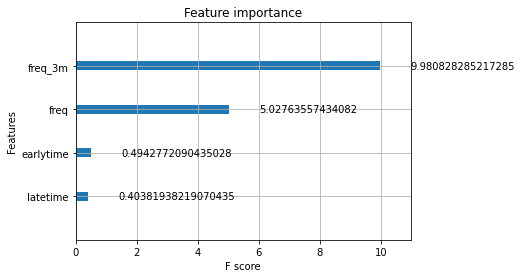

In [56]:
xgb.plot_importance(xgb_model, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

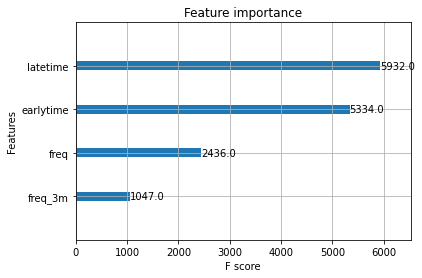

In [57]:
xgb.plot_importance(xgb_model, importance_type='weight')